# ScatteringWavelet Context and RFFNet on PytorchLightening on Turbulent Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from kymatio.torch import Scattering2D
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [4]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


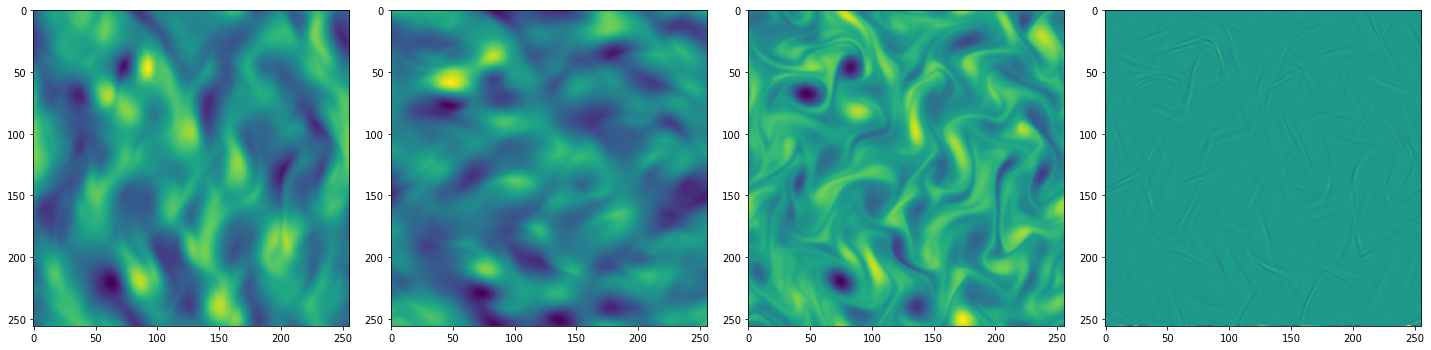

In [5]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

Xtrain shape: (64, 64, 2)
ytrain shape: (64, 64, 2)


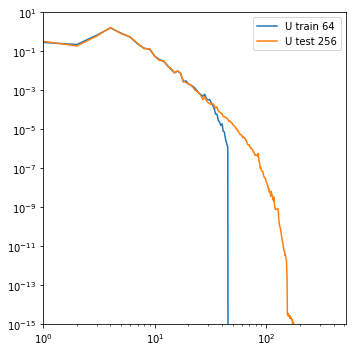

In [6]:
# downsampled resultion
scale = 1/4
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

K41 = np.linspace(0,256,1000)

# b1, b0, _r, _p_val, _stderr = stats.linregress(np.log10(mx), np.log10(my)) 

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

## Scattering-Wavelet Transform Sandbox

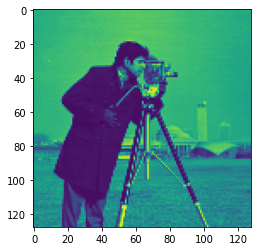

In [7]:
import pywt.data
# Load image
original = pywt.data.camera()
original = original[::4,::4]
plt.imshow(original)
plt.show()

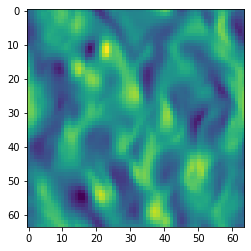

torch.Size([1, 81, 16, 16])


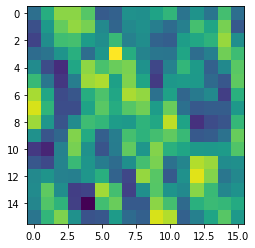

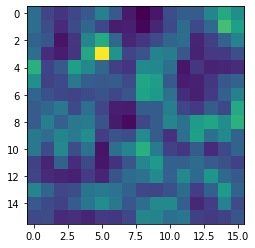

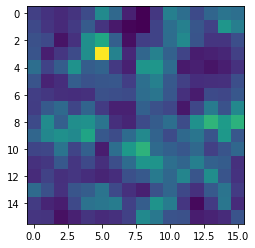

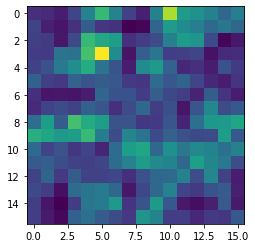

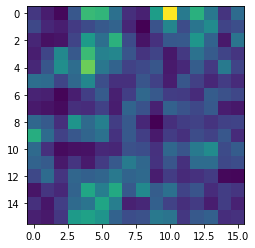

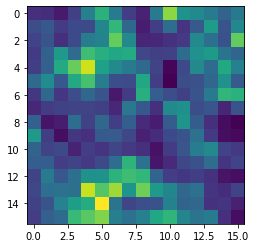

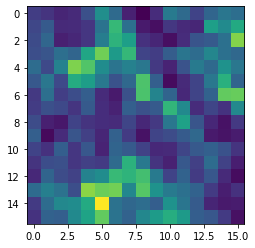

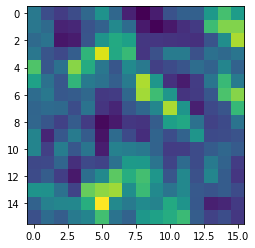

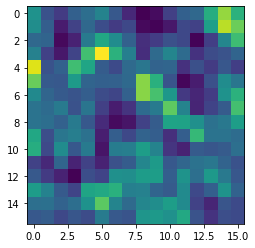

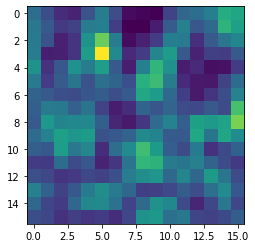

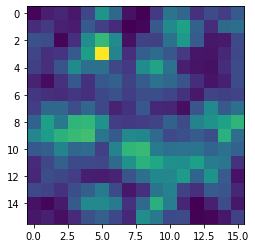

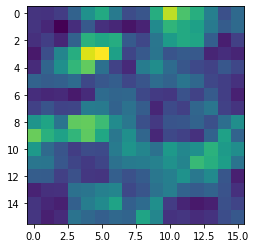

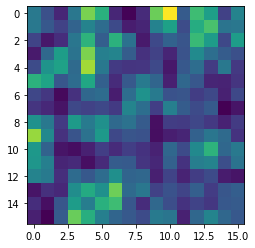

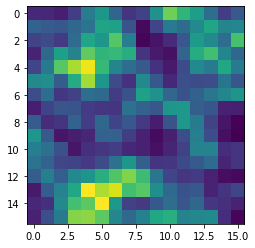

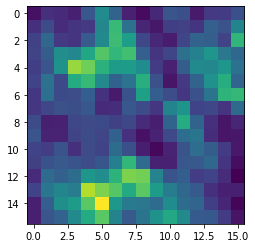

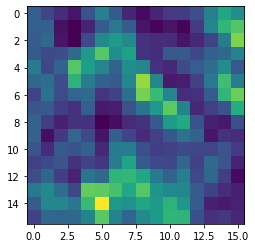

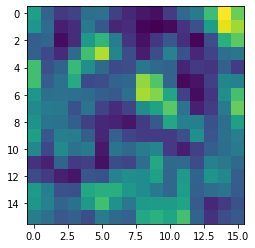

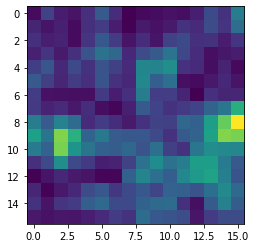

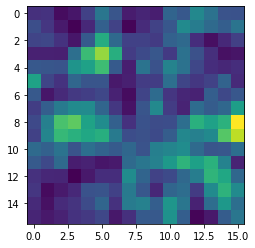

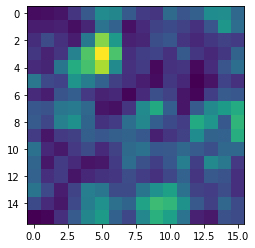

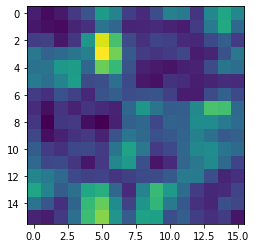

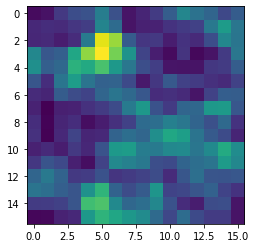

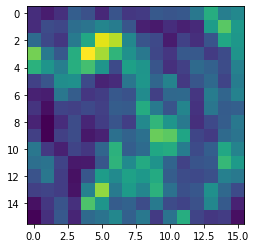

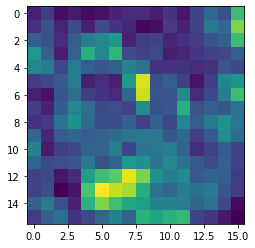

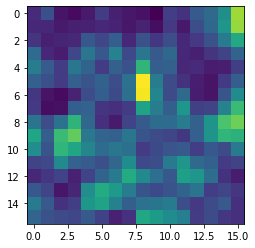

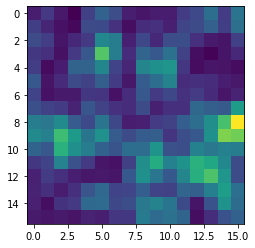

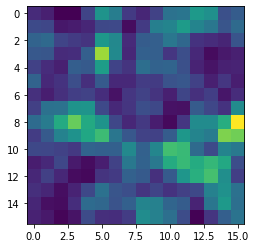

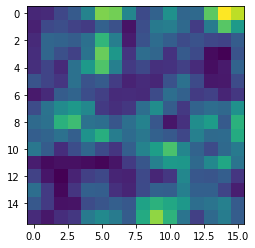

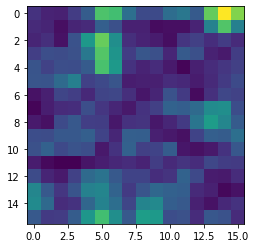

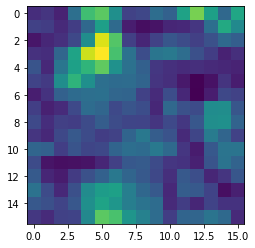

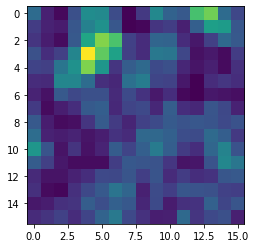

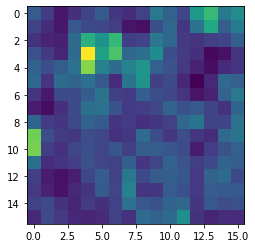

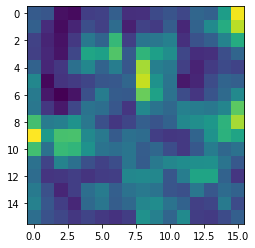

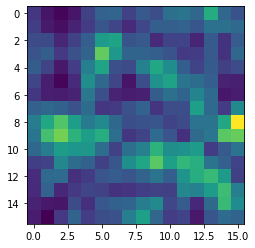

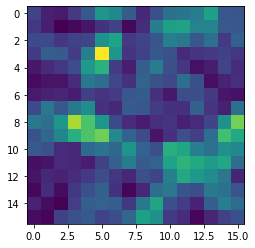

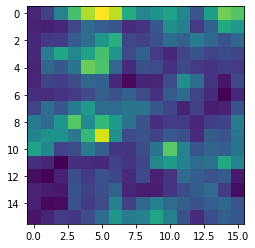

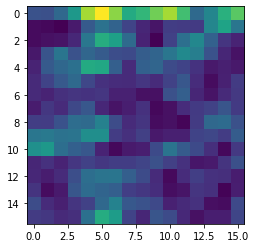

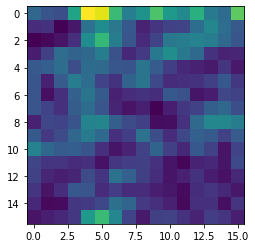

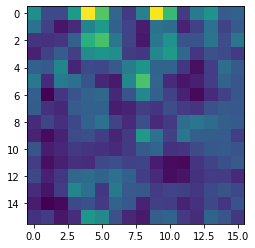

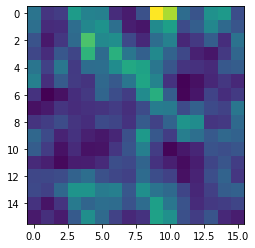

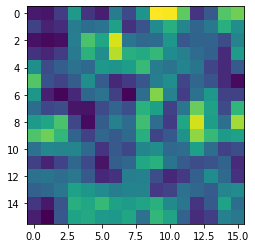

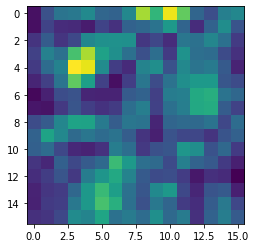

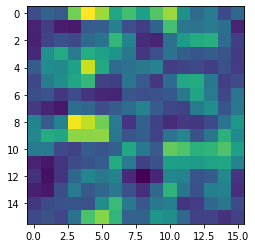

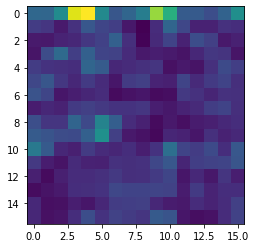

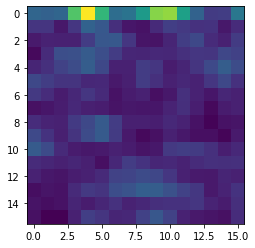

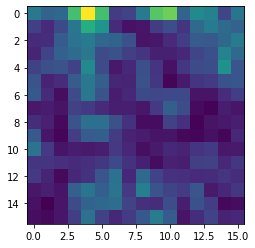

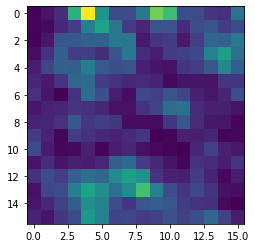

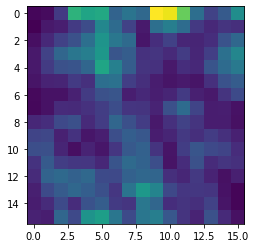

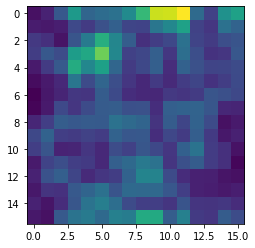

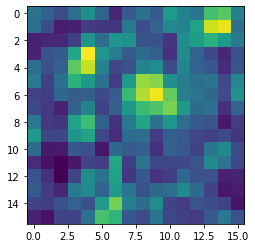

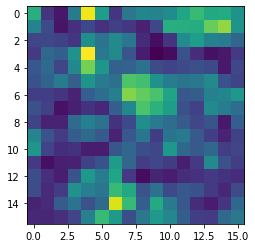

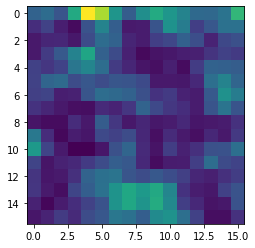

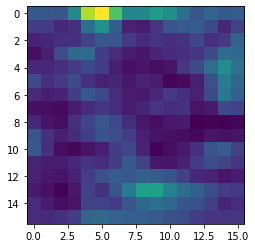

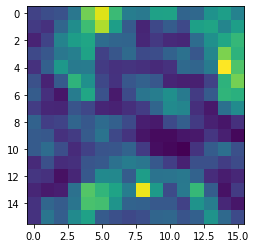

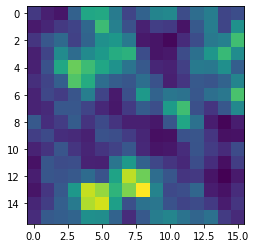

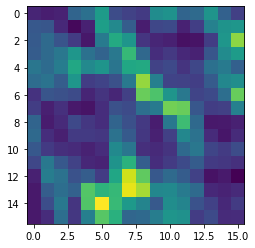

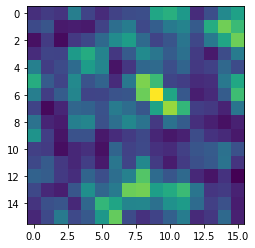

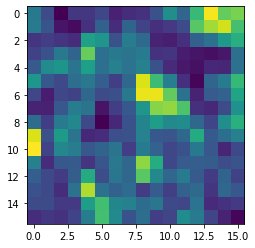

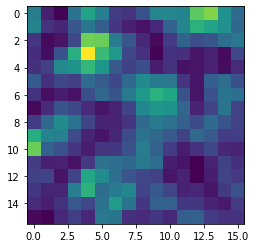

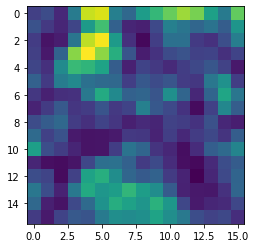

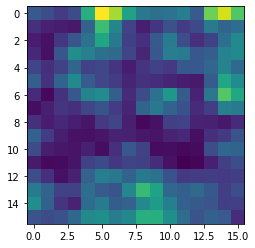

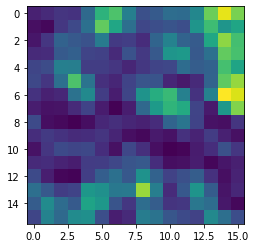

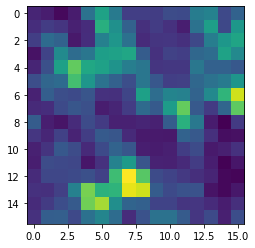

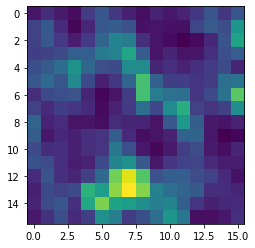

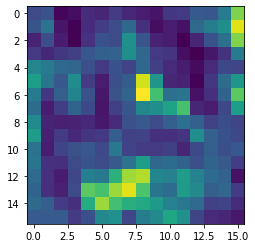

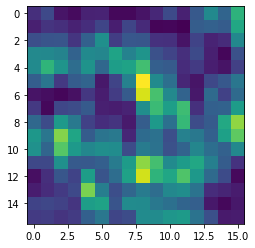

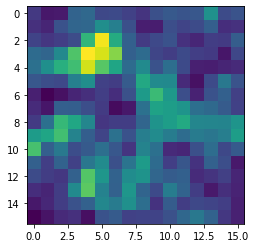

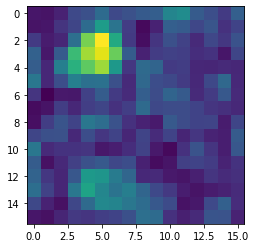

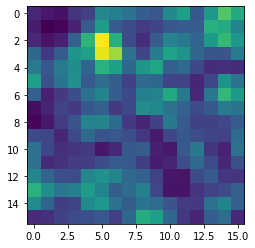

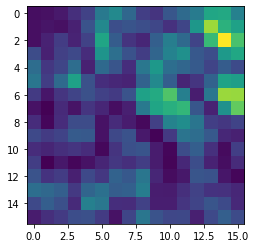

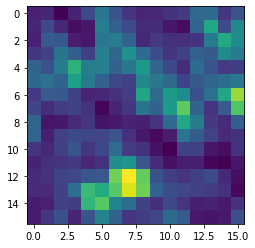

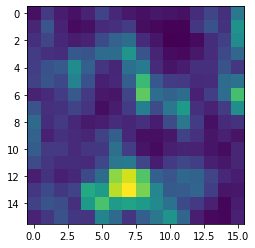

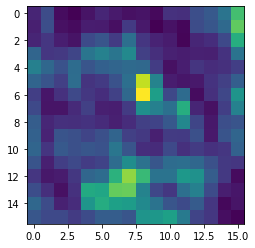

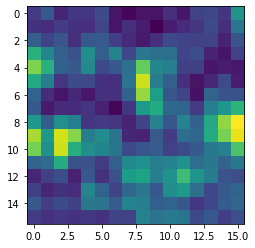

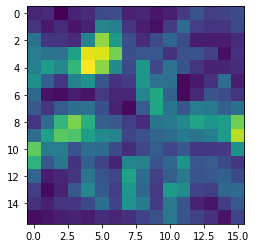

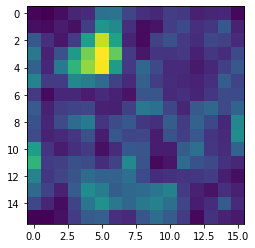

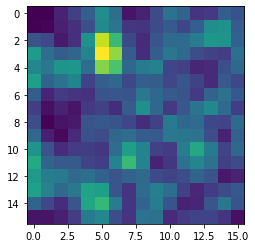

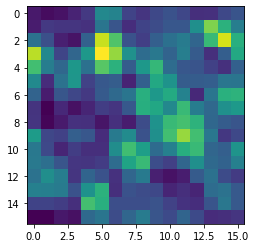

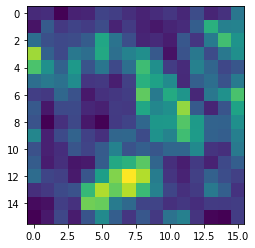

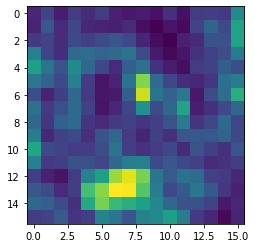

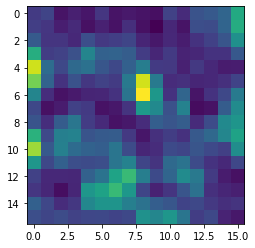

In [8]:
from kymatio.torch import Scattering2D

plt.imshow(ytrain[:,:,0])
plt.show()

x = torch.from_numpy(ytrain[:,:,0]).float().to(device)[None,:,:]
scattering = Scattering2D(J=2, shape=ytrain[:,:,0].shape).cuda()
x = scattering(x)
print(x.shape)

# # upsample
# upsample = torch.nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
# x = upsample(x)
# print(x.shape)

for i in range(0,81):
    plt.imshow(x[0,i,:,:].cpu())
    plt.show()

In [9]:
# print(Xtrain[:,:,0].shape)

# from pytorch_wavelets import DWTForward
# xfm = DWTForward(J=3, wave='db1', mode='zero').to(device)
# x = torch.from_numpy(ytrain[None,None,:,:,0]).float().to(device)
# print(x.shape)
# a, (h,v,d) = xfm(x)

# print(a.shape)
# print(h.shape)
# print(v.shape)
# print(d.shape)

In [10]:
# import pywt
# import pywt.data


# # Load image
# original = pywt.data.camera()
# print(original.shape)

# # Wavelet transform of image, and plot approximation and details
# titles = ['Approximation', ' Horizontal detail',
#           'Vertical detail', 'Diagonal detail']
# coeffs2 = pywt.dwt2(original, 'bior1.3')
# LL, (LH, HL, HH) = coeffs2
# print(LL.shape)
# print(LH.shape)
# print(HL.shape)
# print(HH.shape)
# fig = plt.figure(figsize=(12, 3))
# for i, a in enumerate([LL, LH, HL, HH]):
#     ax = fig.add_subplot(1, 4, i + 1)
#     ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
#     ax.set_title(titles[i], fontsize=10)
#     ax.set_xticks([])
#     ax.set_yticks([])

# fig.tight_layout()
# plt.show()

In [11]:
# print(original.shape)
# wp = pywt.WaveletPacket2D(data=original, wavelet='db1', mode='symmetric')

# fig = plt.figure(figsize=(12, 3))
# for i, a in enumerate(['a', 'h', 'v', 'd']):
#     ax = fig.add_subplot(1, 4, i + 1)
#     ax.imshow(wp[a].data, interpolation="nearest", cmap=plt.cm.gray)
#     ax.set_title(titles[i] + ' res %d' % wp[a].data.shape[0], fontsize=10)
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.show()

# fig = plt.figure(figsize=(12, 3))
# for i, a in enumerate(['aa', 'ah', 'av', 'ad']):
#     ax = fig.add_subplot(1, 4, i + 1)
#     ax.imshow(wp[a].data, interpolation="nearest", cmap=plt.cm.gray)
#     ax.set_title(titles[i] + ' res %d' % wp[a].data.shape[0], fontsize=10)
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.show()

# Dataset

In [7]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        # assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('Dimension error')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8):
        
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)

In [8]:
low_scale = 1/4
Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 64**2,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)

X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
Train
torch.Size([4096, 2]) torch.Size([4096, 2])
Validation
torch.Size([4096, 2]) torch.Size([4096, 2])


# Model

## RFF on batch

In [10]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat=256, scale=10):
        super(Fourier, self).__init__()
        self.b = torch.randn(2, nfeat)*scale
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, dim_mpl_layers, in_shape, f_nfeatures, f_scale, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        
        self.in_shape = in_shape
        
        # regression/pinn network
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = MLP(dim_mpl_layers)
        
        # PINN losses
        self.lam_pde = lam_pde
    
    def forward(self, x): # x := BxC(Batch, InputChannels)

        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x_pred = self.forward(x)

        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)

        # losses 
        loss = loss_rec

        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        
        x_pred = self.forward(x, x_ctxt)
        
        loss = F.mse_loss(x_pred, x_true)
#         psnr = 10 * np.log(2*loss.item())
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

# test network
img_shape = 64
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10
coord_mesh = Xtrain
model = RFFNet_pl(dim_mlp_layers, n_features, scale, device)

print(model)

early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=20, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

TypeError: unsupported operand type(s) for *: 'Tensor' and 'torch.device'

## Contextual RFF

In [68]:
class ContextualRFFNet_pl(pl.LightningModule):
    
    def __init__(self, in_shape, 
                 training_mesh,
                 dim_mpl_layers, f_nfeatures, f_scale,
                 device, lam_pde=1e-4):
        super(ContextualRFFNet_pl, self).__init__()
        
        self.in_shape = in_shape
        
        # regression/pinn network
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = MLP(dim_mpl_layers)
        
        # context network
        assert training_mesh.shape == (in_shape, in_shape,2)
        self.mesh = torch.from_numpy(training_mesh).float().to(device)
        self.mesh = self.mesh.flatten(start_dim=0,end_dim=1)
        self.scat = Scattering2D(J=2, shape=(in_shape, in_shape)).to(device)
        self.up = torch.nn.Upsample(scale_factor=2**2, mode='bilinear', align_corners=True)
        
        # PINN losses
        self.lam_pde = lam_pde
        
    def wavelet_context(self, x):
        ## reshape for 64x64 to be treat as an image
        x = x.transpose(1,0)
        x = x.reshape(2,self.in_shape, self.in_shape)[None,...] # B=1 x 2 x H x W
        ## Scattering-wavelet features
        x = x.contiguous()
        x = self.scat(x) # B=1 x 2 x F x Hl x Wl
        # make Channels=2 and ScattFeatures the same axis 
        x = x.flatten(start_dim=1, end_dim=2) # F x Hl x Wl
        # upsample to match original shape and remove batch dim
        x = self.up(x)[0,...]
        return x
    
    def interpolate_context(self, x, ctxt):
        """ x = B x 2 coordinates
            ctxt = N x F 
        """
        # reshape context for the points
        ctxt = ctxt.flatten(start_dim=1,end_dim=2).transpose(0,1)
        
        # mesh point to mesh index
        mesh_index = self.mesh * self.in_shape
        x_proj = x * self.in_shape
        
        # distance between test and train point
        cdist = torch.cdist(x, self.mesh) # B x F
        # indeces of the one closer
        idx = torch.where(cdist < 1/self.in_shape, True, False)
        weights = torch.zeros_like(cdist).to(x.device) # B x F
        weights[idx] = 1-cdist[idx]
        
        # weights each context point by the distances
        new_ctxt = (weights @ ctxt) / torch.sum(weights, axis=1)[:,None]

        return new_ctxt
        
    def get_context(self, x, x_side, is_training):
        """ x: current points B x Features
            x_side: side information to for computing the context
        """         
        x_ctxt = self.wavelet_context(x_side)
        if not is_training:
            x_ctxt = self.interpolate_context(x, x_ctxt)
        else:
            x_ctxt = x_ctxt.flatten(start_dim=1,end_dim=2).transpose(0,1)
        
        return x_ctxt
    
    def forward(self, x, x_ctxt):
        # x := BxC(Batch, InputChannels)
        # x_side := BxHxW (Batch, OutputChannels)

        ## Fourier features
        x_feat = self.rff(x) # Batch x Fourier Features
        
        ## Attention
        # concatenate fourier features and wavelet features
#         x = torch.cat([x_feat, x_ctxt], axis=-1) # B x AllFeatures
        x = x_feat
        
        ## MLP
        x = self.mlp(x)
        # in lightning, forward defines the prediction/inference actions
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        
        x_ctxt = self.get_context(x, x_true, is_training=True)
        
        x_pred = self.forward(x, x_ctxt)

        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)

        # losses 
        loss = loss_rec

        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        
        x_ctxt = self.get_context(x, x_true, is_training=False)
        
        x_pred = self.forward(x, x_ctxt)
        
        loss = F.mse_loss(x_pred, x_true)
#         psnr = 10 * np.log(2*loss.item())
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

# test network
img_shape = 64
n_features = 256
dim_layers = [2*n_features + 162] + 3*[256] + [2]
scale = 10
coord_mesh = Xtrain
model = ContextualRFFNet_pl(img_shape, coord_mesh, dim_layers, n_features, scale, device)

model.to(device)
# x = torch.from_numpy(Xtrain.reshape(64**2,2)).float().to(device)
step = 1/img_shape
x = torch.from_numpy(np.array([[0,0],[step,0],[0,step],[step,step],[3*step/2,3*step/2]])).float().to(device)
x_side = torch.from_numpy(ylow).float().to(device)
x_pred = model.get_context(x, x_side, is_training=False)
print(x_pred.shape)

torch.Size([5, 162])


In [ ]:
# test network
img_shape = 64
n_features = 256
dim_layers = [2*n_features] + 3*[256] + [2]
scale = 10
coord_mesh = Xtrain
model = ContextualRFFNet_pl(img_shape, coord_mesh, dim_layers, n_features, scale, device)

print(model)

early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=20, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | rff  | Fourier      | 0     
1 | mlp  | MLP          | 263 K 
2 | scat | Scattering2D | 0     
3 | up   | Upsample     | 0     
--------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)


ContextualRFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
  (scat): Scattering2D()
  (up): Upsample(scale_factor=4.0, mode=bilinear)
)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(4096, 2)


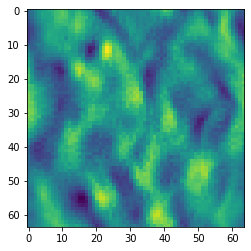

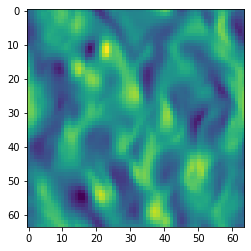

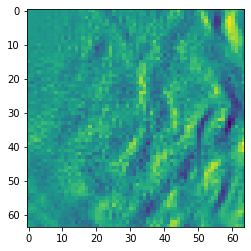

In [65]:
ngrid = 64
model.eval().to(device)
coords = np.linspace(0, 1, ngrid, endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)
side = torch.from_numpy(ylow).float().contiguous().to(device)
ctxt = model.get_context(x, side, is_training=False)

pred = model(x, ctxt)
ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

plt.imshow(ytrain[:,:,0])
plt.show()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0] - ytrain[:,:,0])
plt.show()
